# Radar Chart

## Importing Required Libraries

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mplsoccer import PyPizza, add_image, FontManager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
from adjustText import adjust_text
import matplotlib.patheffects as path_effects
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text
from tabulate import tabulate
import matplotlib.style as style
from mplsoccer import Radar, FontManager, grid


pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#463F3A"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

## The data for this plot is being gathered from FBref, however due to firewall issues I am unable to use scraper libs, so for now using google sheets to copy data from Fbref and calling those sheets from below function

In [83]:
import re

def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for CSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

In [85]:
# Replace with your modified URL
player_1_url = 'https://docs.google.com/spreadsheets/d/1JKYyDJX06Ut7Zk0DdMeeY5FL-wP1vmhaK56h5C0hLn4/edit?pli=1#gid=926075340'
player_1_new_url = convert_google_sheet_url(player_1_url)

player_2_url = 'https://docs.google.com/spreadsheets/d/1JKYyDJX06Ut7Zk0DdMeeY5FL-wP1vmhaK56h5C0hLn4/edit#gid=1605381867'
player_2_new_url = convert_google_sheet_url(player_2_url)

## Creating dataframes for the two players to compare

In [86]:
df_player_1 = pd.read_csv(player_1_new_url)
df_player_2 = pd.read_csv(player_2_new_url)
df_player_1 = df_player_1.transpose()
df_player_1.columns = df_player_1.iloc[0]
df_player_1 = df_player_1[1:]
df_player_1['Name'] = 'Jude Bellingham'
df_player_1['Pass Completion %'] = df_player_1['Pass Completion %'].str.replace('%', '')


df_player_2 = df_player_2.transpose()
df_player_2.columns = df_player_2.iloc[0]
df_player_2 = df_player_2[1:]
df_player_2['Name'] = 'Phil Foden'
df_player_2['Pass Completion %'] = df_player_2['Pass Completion %'].str.replace('%', '')

## Transforming the dataframes

In [90]:
df_player_1 = df_player_1.drop(['npxG + xAG','Progressive Passes Rec'],axis=1)
df_player_2 = df_player_2.drop(['npxG + xAG','Progressive Passes Rec'],axis=1)

player_1_values =   df_player_1.iloc[0].to_list()
player_2_values =  df_player_2.iloc[0].to_list()

player_1_attacking_values = player_1_values[0:6]
player_2__attacking_values = player_2_values[0:6]
player_1_attacking_values = [float(value) for value in player_1_attacking_values]
player_2__attacking_values = [float(value) for value in player_2__attacking_values]

player_1_playmaking_values = player_1_values[6:12]
player_2__playmaking_values = player_2_values[6:12]
player_1_playmaking_values = [float(value) for value in player_1_playmaking_values]
player_2__playmaking_values = [float(value) for value in player_2__playmaking_values]

player_1_defending_values = player_1_values[12:17]
player_2_defending_values = player_2_values[12:17]
player_1_defending_values = [float(value) for value in player_1_defending_values]
player_2_defending_values = [float(value) for value in player_2_defending_values]

## Creating base parameters for the Radars

In [87]:
# parameter names of the statistics we want to show
params_attacking = ["Non-Penalty Goals", "npxG", "Shots", "Assists", "xAG","Shot-Creating Actions"]

params_playmaking = ["Passes Attempted","Pass Completion %", "Progressive Passes", "Progressive Carries", "Successful Take-Ons",
                     "Touches (Att Pen)"]

params_defending = ["Tackles","Interceptions","Blocks","Clearances","Aerials Won"]

# The lower and upper boundaries for the statistics
low_attacking =  [0.2,0.2,1,0.2,0.2,4]
high_attacking = [0.6,0.4,4,0.4,0.35,6]

low_playmaking =  [40,70,3,3,1,6]
high_playmaking = [60,90,6,6,2,8]

low_defending =  [0,0.25,0,0,0]
high_defending = [3,0.5,1.5,1,1]

radar_attacking = Radar(params_attacking, low_attacking, high_attacking,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params_attacking),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

radar_playmaking = Radar(params_playmaking, low_playmaking, high_playmaking,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params_playmaking),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

radar_defending = Radar(params_defending, low_defending, high_defending,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params_defending),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

In [88]:
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

## Attacking Radar Chart

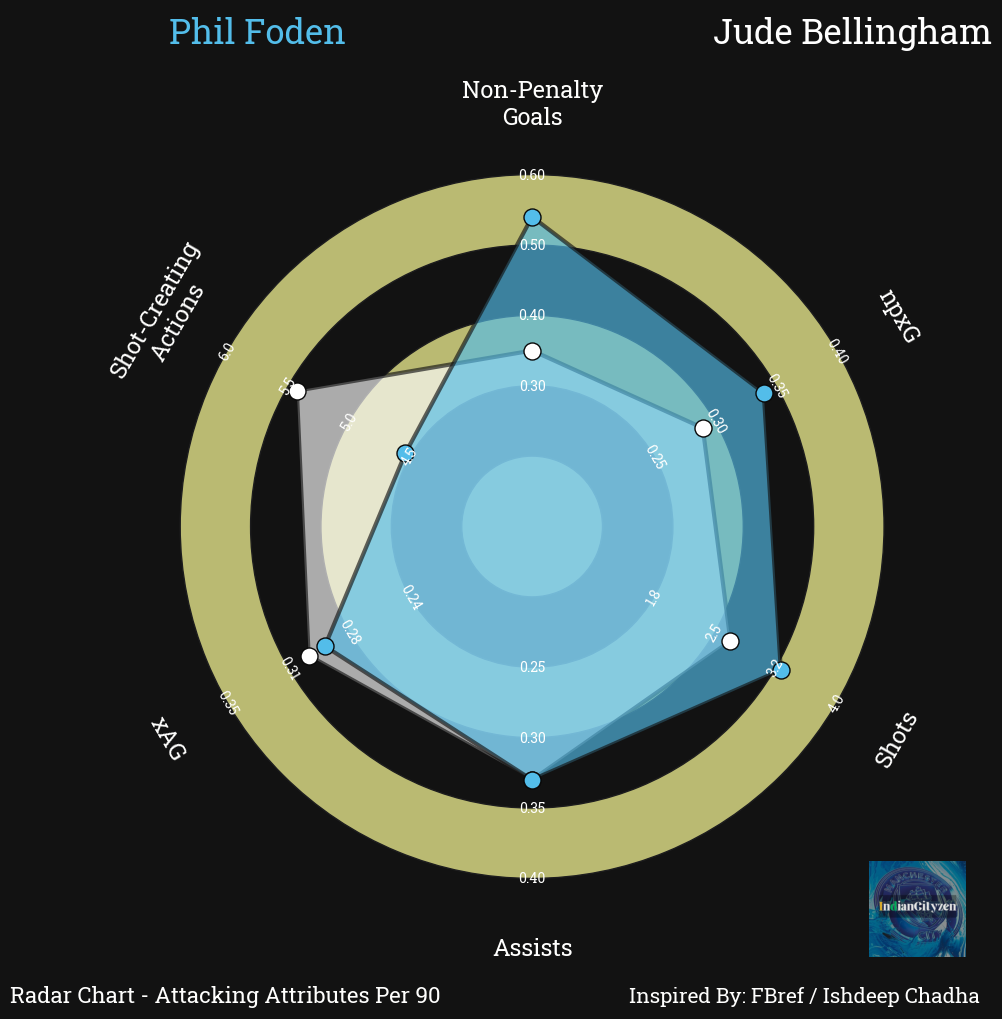

In [91]:
# plot radar
fig, axs = grid(figheight=10, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot the radar
radar_attacking.setup_axis(ax=axs['radar'],facecolor='#121212')
rings_inner = radar_attacking.draw_circles(ax=axs['radar'], facecolor='#BABA72', edgecolor='#1D1D1E')

radar1, vertices1 = radar_attacking.draw_radar_solid(player_1_attacking_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#FFFFFF',
                                                   'alpha': 0.65,
                                                   'edgecolor': '#131313',
                                                   'lw': 3})

radar2, vertices2 = radar_attacking.draw_radar_solid(player_2__attacking_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#53BDEA',
                                                   'alpha': 0.65,
                                                   'edgecolor': '#131313',
                                                   'lw': 3})

axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
           c='#FFFFFF', edgecolors='#090909', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
           c='#53BDEA', edgecolors='#090909', marker='o', s=150, zorder=2)

range_labels = radar_attacking.draw_range_labels(ax=axs['radar'], fontsize=10, fontproperties=robotto_bold.prop,color='#FFFFFE')
param_labels = radar_attacking.draw_param_labels(ax=axs['radar'], fontsize=17, fontproperties=robotto_bold.prop,color='#FFFFFE')

# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text1 = axs['endnote'].text(0.99, 0.5, 'Inspired By: FBref / Ishdeep Chadha', fontsize=15,
                                   fontproperties=robotto_bold.prop, ha='right', va='center',color='#FFFFFE')
header_text2 = axs['endnote'].text(0.4, 0.5, 'Radar Chart - Attacking Attributes Per 90', fontsize=16,
                                fontproperties=robotto_bold.prop, ha='right', va='center',color='#FFFFFE')


logo = mpimg.imread('Images/IndianCityzen.png')


ax_image = add_image(
    logo, fig, left=0.85, bottom=0.05, width=0.1, height=0.1,alpha=0.9,aspect='equal'
)

title1_text = axs['title'].text(0.2, 0.6, 'Phil Foden', fontsize=25,
                               fontproperties=robotto_bold.prop, ha='center', va='center',color='#53BDEA')
#title3_text = axs['title'].text(0.46, 0.65, 'V', fontsize=20,
                                #fontproperties=robotto_bold.prop, ha='center', va='center',color='#FFFFFE')
title2_text = axs['title'].text(0.85, 0.6, 'Jude Bellingham', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='center', va='center',color='#FFFFFF')

fig.set_facecolor('#121212')
plt.savefig('Charts/PhilVJude(A).png',dpi=300,bbox_inches = 'tight',facecolor='#121212')

## Playmaking Radar Plot

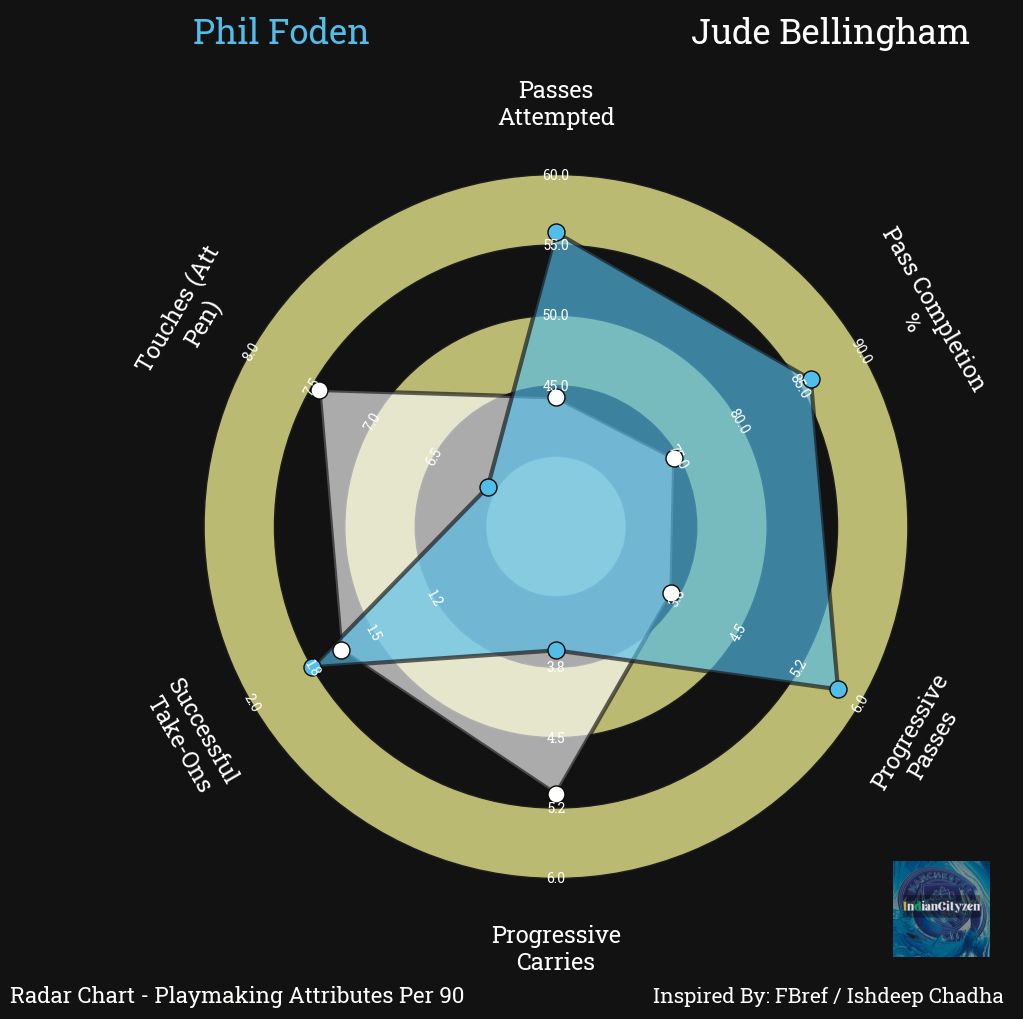

In [92]:
# plot radar
fig, axs = grid(figheight=10, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot the radar
radar_playmaking.setup_axis(ax=axs['radar'],facecolor='#121212')
rings_inner = radar_playmaking.draw_circles(ax=axs['radar'], facecolor='#BABA72', edgecolor='#1D1D1E')

radar1, vertices1 = radar_playmaking.draw_radar_solid(player_1_playmaking_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#FFFFFF',
                                                   'alpha': 0.65,
                                                   'edgecolor': '#131313',
                                                   'lw': 3})

radar2, vertices2 = radar_playmaking.draw_radar_solid(player_2__playmaking_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#53BDEA',
                                                   'alpha': 0.65,
                                                   'edgecolor': '#131313',
                                                   'lw': 3})

axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
           c='#FFFFFE', edgecolors='#090909', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
           c='#53BDEA', edgecolors='#090909', marker='o', s=150, zorder=2)

range_labels = radar_playmaking.draw_range_labels(ax=axs['radar'], fontsize=10, fontproperties=robotto_bold.prop,color='#FFFFFE')
param_labels = radar_playmaking.draw_param_labels(ax=axs['radar'], fontsize=17, fontproperties=robotto_bold.prop,color='#FFFFFE')

# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text1 = axs['endnote'].text(0.99, 0.5, 'Inspired By: FBref / Ishdeep Chadha', fontsize=15,
                                   fontproperties=robotto_bold.prop, ha='right', va='center',color='#FFFFFE')
header_text2 = axs['endnote'].text(0.4, 0.5, 'Radar Chart - Playmaking Attributes Per 90', fontsize=16,
                                fontproperties=robotto_bold.prop, ha='right', va='center',color='#FFFFFE')

logo = mpimg.imread('Images/IndianCityzen.png')


ax_image = add_image(
    logo, fig, left=0.85, bottom=0.05, width=0.1, height=0.1,alpha=0.9,aspect='equal'
)

title1_text = axs['title'].text(0.2, 0.6, 'Phil Foden', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='center', va='center',color='#53BDEA')

title2_text = axs['title'].text(0.8, 0.6, 'Jude Bellingham', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='center', va='center',color='#FFFFFF')

fig.set_facecolor('#121212')
plt.savefig('Charts/PhilVJude(P).png',dpi=300,bbox_inches = 'tight',facecolor='#121212')

## Defensive Radar Plot

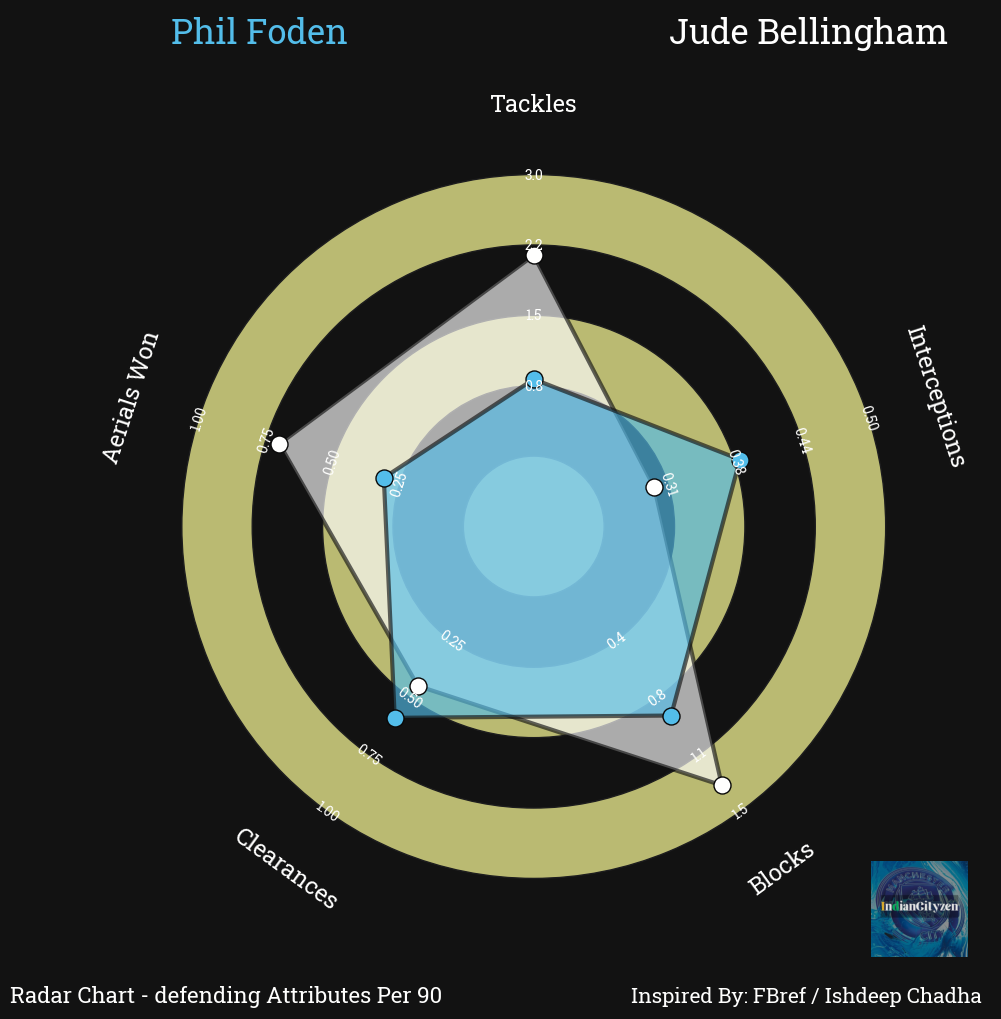

In [93]:
# plot radar
fig, axs = grid(figheight=10, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot the radar
radar_defending.setup_axis(ax=axs['radar'],facecolor='#121212')
rings_inner = radar_defending.draw_circles(ax=axs['radar'], facecolor='#BABA72', edgecolor='#1D1D1E')

radar1, vertices1 = radar_defending.draw_radar_solid(player_1_defending_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#FFFFFF',
                                                   'alpha': 0.65,
                                                   'edgecolor': '#131313',
                                                   'lw': 3})

radar2, vertices2 = radar_defending.draw_radar_solid(player_2_defending_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#53BDEA',
                                                   'alpha': 0.65,
                                                   'edgecolor': '#131313',
                                                   'lw': 3})

axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
           c='#FFFFFE', edgecolors='#090909', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
           c='#53BDEA', edgecolors='#090909', marker='o', s=150, zorder=2)

range_labels = radar_defending.draw_range_labels(ax=axs['radar'], fontsize=10, fontproperties=robotto_bold.prop,color='#FFFFFE')
param_labels = radar_defending.draw_param_labels(ax=axs['radar'], fontsize=17, fontproperties=robotto_bold.prop,color='#FFFFFE')

# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text1 = axs['endnote'].text(0.99, 0.5, 'Inspired By: FBref / Ishdeep Chadha', fontsize=15,
                                   fontproperties=robotto_bold.prop, ha='right', va='center',color='#FFFFFE')
header_text2 = axs['endnote'].text(0.4, 0.5, 'Radar Chart - defending Attributes Per 90', fontsize=16,
                                fontproperties=robotto_bold.prop, ha='right', va='center',color='#FFFFFE')

logo = mpimg.imread('Images/IndianCityzen.png')

ax_image = add_image(
    logo, fig, left=0.85, bottom=0.05, width=0.1, height=0.1,alpha=0.9,aspect='equal'
)

title1_text = axs['title'].text(0.2, 0.6, 'Phil Foden', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='center', va='center',color='#53BDEA')

title2_text = axs['title'].text(0.8, 0.6, 'Jude Bellingham', fontsize=25,
                                fontproperties=robotto_bold.prop, ha='center', va='center',color='#FFFFFF')

fig.set_facecolor('#121212')
plt.savefig('Charts//PhilVJude(D).png',dpi=300,bbox_inches = 'tight',facecolor='#121212')

# Bonus Plot - Age V Minutes Played for a Squad

In [94]:
city_url = 'https://docs.google.com/spreadsheets/d/1HkqbTlQeWw-NzhMUDuRjvqa8irKVtbSg84r0Muq5Dfc/edit#gid=511292703'
city_new_url = convert_google_sheet_url(city_url)

In [97]:
def squad_age_profile_chart(df, team_name):
    df["Age"] = df["Age"].str[:2]
    df['Min'] = df['Min'].str.replace(',','')
    df[["Age","Min"]] = df[["Age","Min"]].apply(pd.to_numeric)

    total_matches_played = 28
    total_minutes = 28 * 90 # Not taking injury time as of now
    df["Min_pct"] = (df['Min'] / total_minutes) * 100
    df["Min_pct"] = df["Min_pct"].round(2)
    df = df.dropna(subset=["Age", "Min_pct"])
    df = df.loc[:len(df)-1, :]

    line_color = "silver"
    text_color = "black"
    marker_color = "dodgerblue"
    fig, ax = plt.subplots(figsize=(12, 8))

    # plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
    #style.use('fivethirtyeight')
    ax.scatter(df["Age"], df["Min_pct"],alpha=0.9) ##scatter points
    ax.fill([24, 29, 29, 24], [-6, -6, 106, 106], color='limegreen',
            alpha=0.3, zorder=2) ##the peak age shaded region
    ax.text(26.5, 55, "PEAK", color=line_color, zorder=3, 
            alpha=1, fontsize=26, rotation=90, ha='center',
            va='center', fontweight='bold') ## `PEAK` age text
    texts = [] ##plot player names
    for row in df.itertuples():
        texts.append(ax.text(row.Age, row.Min_pct, row.Player, fontsize=9, ha='center', va='center', zorder=10))

    ## update plot
    ax.set(xlabel="Age", ylabel="Share of Minutes Played %", ylim=(-5, 105), xlim=(16, 40)) ## set labels and limits
    ax.set_xlabel("Age", color='#FFFEFE',fontsize=15)
    ax.set_ylabel("Share of Minutes Played %", color='#FFFEFE',fontsize=15)

    ##grids and spines
    ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
        ax.spines[spine].set_color(line_color)
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.xaxis.set_ticks(range(16, 44, 4)) ##fix the tick frequency 
    #ax.xaxis.label.set(fontsize=10)
    #ax.yaxis.label.set(fontsize=10) ## increase the weight of the axis labels

    ax.set_position([0.08, 0.08, 0.82, 0.78]) ## make space for the title on top of the axes

    ## title and subtitle
    fig.text(x=0.08, y=0.92, s=f"{team_name} | Squad Age Profile", 
            ha='left', fontsize=22, fontweight='book',color='#FFFEFE') 
    fig.text(x=0.08, y=0.88, s=f"EPL | 2023-24", ha='left', 
            fontsize=20, fontweight='book',color='#FFFEFE')

    logo = mpimg.imread('Images/IndianCityzen.png')
    city = mpimg.imread('Images/TeamLogos/ManchesterCity.png')
    ax_image = add_image(
    logo, fig, left=0.8, bottom=0.1, width=0.1, height=0.1,alpha=0.9,aspect='equal'
    )

    ax_image = add_image(
    city, fig, left=0.8, bottom=0.87, width=0.1, height=0.1,alpha=0.9,aspect='equal'
    )
    
    fig.set_facecolor('#121212')
    plt.savefig('Charts/AgeVsMinutesPlayed.png',dpi=300,bbox_inches = 'tight',facecolor='#121212')

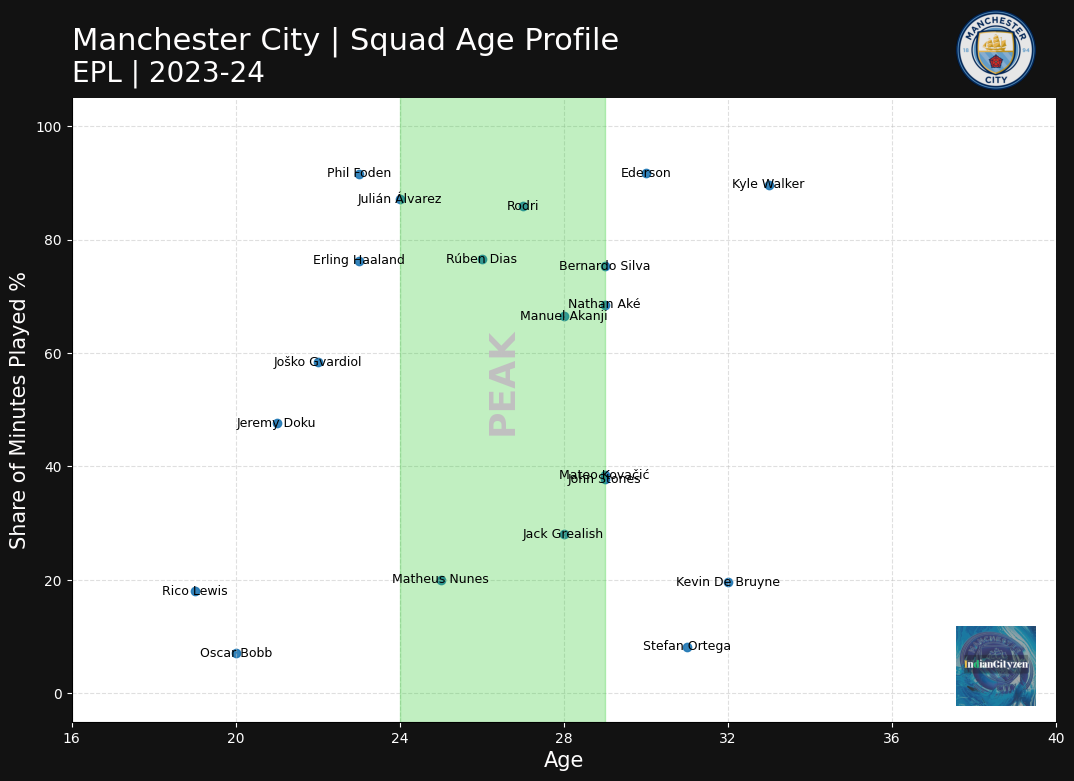

In [98]:
df = pd.read_csv(city_new_url)
squad_age_profile_chart(df,'Manchester City')